In [12]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import zipfile, os, re
import glob

In [13]:
#Header Data
VicRoadsHeader_URL = 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/VicRoads_Bike_Site_Number_Listing.xlsx'

#Yearly Data
Bicycle_Vol = {'Bicycle_Vol_2021_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2021.zip',
               'Bicycle_Vol_2020_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2020.zip',
               'Bicycle_Vol_2019_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2019.zip',
               'Bicycle_Vol_2018_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2018.zip',
               'Bicycle_Vol_2017_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2017.zip',
               'Bicycle_Vol_2016_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2016.zip',
               'Bicycle_Vol_2015_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_speed_2015.zip'}

In [14]:
#create folders for storing data

#ensure home directory is the home director of this program (i.e. c:\Users\Study\Documents\Github)...  Not  sure what this does, but sounded good so added it.
os.chdir(os.getcwd())
home = os.getcwd()
print("Home file = " + home)

#create folder called data in the home dir
datafolder = os.path.join(home,'data') 
if os.path.exists(datafolder) == False:
    os.mkdir(datafolder)
    print("Made directory = " + datafolder)

Home file = c:\Users\Study\Documents\Github\Hello


In [15]:
#download header and write it to header excel file
Header = requests.get(VicRoadsHeader_URL)
saveFile = os.path.join(datafolder, 'VicRoadsHeader.xlsx')

with open(saveFile,'wb') as output:
        output.write(Header.content)
        print("File Saved = " + saveFile)

File Saved = c:\Users\Study\Documents\Github\Hello\data\VicRoadsHeader.xlsx


In [16]:
#read the first lines of VicRoads Header File
df = pd.read_excel(saveFile)
print(df.head())

   SITE_ID  TFM_ID  STRT_LAT  STRT_LONG                       GPS  SITE_NAME  \
0     6411   59437 -37.77231  144.99042  [-37.772347 +144.990631]  D208X6411   
1     6411   59438 -37.77235  144.99077  [-37.772347 +144.990631]  D208X6411   
2     6415   59485 -37.82713  144.98511  [-37.827009 +144.984261]  D208X6415   
3     6415   59486 -37.82714  144.98513  [-37.827009 +144.984261]  D208X6415   
4     6419   59458 -37.75829  144.98039  [-37.758216 +144.980308]  D208X6419   

                                            TFM_DESC BEARING_DESC DATA_SRC_CD  \
0  (BIKE PATH) ST. GEORGES RD N BD 28M S OF SUMNE...  NORTH BOUND       ACBYC   
1  (BIKE PATH) ST. GEORGES RD S BD 28M S OF SUMNE...  SOUTH BOUND       ACBYC   
2  (BIKE PATH) NORTH BANK E BD 75M W OF MORELL BR...   EAST BOUND       ACBYC   
3  (BIKE PATH) NORTH BANK W BD 75M W OF MORELL BR...   WEST BOUND       ACBYC   
4  (BIKE PATH) MERRI CREEK TRAIL N BD S OF MORELA...  NORTH BOUND       ACBYC   

       RGN_SHORT_NM             

In [17]:
#move on to the data files
#create an empty list to idenitfy the list zips once created.
Bicycle_Vol_Zip_Files = []

#subset the list to just one zip file for testing purposes
#[Testing routine - delete]
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
n_items = take(1, Bicycle_Vol.items()) 
print("Dictionary file, [Name, Zip File] = ", n_items) 

#download zips from website and label using as subset of the dictionary for the URLs  
for key, value in n_items: #replace n_items with Bicycle_Vol.items() when testing is resolved
    resp = requests.get(value)
    saveFile = os.path.join(datafolder, key[:-4] + '.zip')
    with open(saveFile,'wb') as output: #remove the URL part of the key
        output.write(resp.content)
        print("File Saved = " + saveFile)
        Bicycle_Vol_Zip_Files.append(saveFile) #Populate the empty list with filenames.

Dictionary file, [Name, Zip File] =  [('Bicycle_Vol_2021_URL', 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2021.zip')]
File Saved = c:\Users\Study\Documents\Github\Hello\data\Bicycle_Vol_2021.zip


In [18]:
def extract_nested_zip(zippedFile, datafolder):
       #Unzip a zip file and its contents, including nested zip files
       # Delete the zip file(s) after extraction 
       # Credit - Stackoverflow - ronnydw answered May 10 '17 at 14:47
    
    print("Opening File =" + zippedFile + " | Extracting to Folder = " +  datafolder)
    
    with zipfile.ZipFile(zippedFile, 'r') as zfile:
        zfile.extractall(path=datafolder)
    os.remove(zippedFile) #Delete the zip once extracted.  This is required as the routine repeats until it doesn't find a zip file.

    #search the dir for zips and send it back to the start of the function.
    for root, dirs, files in os.walk(datafolder):
        for filename in files:
            #print(os.path.join(datafolder, filename))
            if re.search(r'zip$', filename):
                fileSpec = os.path.join(root, filename)
                try:
                    print(fileSpec)
                    extract_nested_zip(fileSpec, root)
                except:
                    print("Error! - Couldn't find the file: " + zippedFile)  
                    break                                                           #Many errors thrown as the routine is too quick and doesn't wait for the zip file to be extracted before it goes again.

In [19]:
#extract all data into the data folder.  Delete all zips and keep going until there are no more zips.
for File in Bicycle_Vol_Zip_Files:
    extract_nested_zip(File, datafolder)

Opening File =c:\Users\Study\Documents\Github\Hello\data\Bicycle_Vol_2021.zip | Extracting to Folder = c:\Users\Study\Documents\Github\Hello\data
c:\Users\Study\Documents\Github\Hello\data\2021-01-04_IND.zip
Opening File =c:\Users\Study\Documents\Github\Hello\data\2021-01-04_IND.zip | Extracting to Folder = c:\Users\Study\Documents\Github\Hello\data
c:\Users\Study\Documents\Github\Hello\data\2021-01-11_IND.zip
Opening File =c:\Users\Study\Documents\Github\Hello\data\2021-01-11_IND.zip | Extracting to Folder = c:\Users\Study\Documents\Github\Hello\data
c:\Users\Study\Documents\Github\Hello\data\2021-01-12_IND.zip
Opening File =c:\Users\Study\Documents\Github\Hello\data\2021-01-12_IND.zip | Extracting to Folder = c:\Users\Study\Documents\Github\Hello\data
c:\Users\Study\Documents\Github\Hello\data\2021-01-18_IND.zip
Opening File =c:\Users\Study\Documents\Github\Hello\data\2021-01-18_IND.zip | Extracting to Folder = c:\Users\Study\Documents\Github\Hello\data
c:\Users\Study\Documents\Githu

In [20]:
#clean up any CSV files that don't have an extension and make it a CSV file
for root, dirs, files in os.walk(datafolder):
    for filename in files:
        filename_ext = os.path.splitext(filename)[1]
        if re.search('\d', filename_ext):  #check the extension for numbers to identify bad data files with numbers as extensions
            filename.replace(".csv.","_") #remove csv from this extension
            os.rename(os.path.join(datafolder,filename), os.path.join(datafolder,filename + '.csv'))

In [21]:
#join all CSV's into a dataframe
all_files = glob.glob(datafolder + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
print(frame.head())


  DATA_TYPE TIS_DATA_REQUEST SITE_XN_ROUTE LOC_LEG        DATE      TIME  \
0       IND              208         10223   59443  28/12/2020  05:29:22   
1       IND              208         10223   59443  28/12/2020  05:33:26   
2       IND              208         10223   59444  28/12/2020  05:40:45   
3       IND              208         10223   59444  28/12/2020  05:42:57   
4       IND              208         10223   59443  28/12/2020  05:44:19   

  CLASS LANE  SPEED  WHEELBASE  HEADWAY     GAP AXLE  AXLE_GROUPING  RHO  \
0    15    0   30.2        1.1   5166.7  5166.7    2            1.0  1.0   
1    15    0   29.4        1.0    244.2   244.1    2            1.0  1.0   
2    15    1   13.2        1.0   5849.7  5849.9    2            1.0  1.0   
3    15    1   14.9        1.1    131.9   131.7    2            1.0  1.0   
4    15    0   32.9        1.0    652.5   652.4    2            1.0  1.0   

  VEHICLE DIRECTION  
0   CYCLE         N  
1   CYCLE         N  
2   CYCLE         S 

In [ ]:
frame.describe()

,SPEED,WHEELBASE,HEADWAY,GAP,AXLE_GROUPING,RHO
count,9.919805e+06,9.412784e+06,9.412784e+06,9.412784e+06,9.412784e+06,9.919805e+06
mean,2.089927e+01,1.025703e+00,2.270537e+02,2.302533e+02,1.000039e+00,9.836581e-01
std,6.552737e+00,9.262843e-02,1.611167e+03,1.935394e+03,6.252541e-03,8.865124e-02
min,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.670000e+01,1.000000e+00,6.500000e+00,6.300000e+00,1.000000e+00,1.000000e+00
50%,2.080000e+01,1.000000e+00,4.580000e+01,4.560000e+01,1.000000e+00,1.000000e+00
75%,2.500000e+01,1.100000e+00,1.421000e+02,1.419000e+02,1.000000e+00,1.000000e+00
max,1.592000e+02,1.440000e+01,8.640000e+04,6.357559e+05,3.000000e+00,1.380000e+00


So... this data shows we have 7.63M rows of data. Some data is not consistent across all files.  So we might have incomplete files.  This is only one year too...
How do i ensure I don't have duplicates that have gone through at the same time?
How cool would it be to see a map of melbourne and see a blink every time a bike went past a counter?
How many people are recorded at different areas and disappear from the next likely stop?  What are the possibilities for those people?  Stop at the shops?  Go an alterative route?

In [ ]:
#frame['VEHICLE'].describe() 
frame['DATE'].describe()

count        9919805
unique           470
top       28/08/2021
freq           61208
Name: DATE, dtype: object

In [ ]:
frame['DATE'] = pd.to_datetime(frame['DATE'])
speeddf = frame.groupby(frame['DATE'].dt.strftime('%B'))['SPEED'].mean()
#need to add median, std, top 25, count, top 75, max

KeyError: 'DATE'

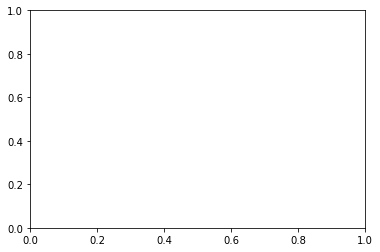

In [ ]:
fig, ax = plt.subplots()
ax.plot(speeddf['DATE'], speeddf['SPEED'], marker ='o', linestyle='--', color='r')
ax.set_xlabel("Time (months)")
ax.set_ylabel("km/h")
#ax.plot(frame['DATE'], frame['WHEELBASE'])
date_form = DateFormatter("%y-%d")
ax.xaxis.set_major_formatter(date_form)
plt.show()